# Import libraries

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Import data

In [98]:
data = pd.read_csv('starbucks.csv', index_col='Date') # We want the date to be index
data.index = pd.to_datetime(data.index) # Convert from Index to DatetimeIndex
data.head()

# Note : always convert index to datetime

,Close,Volume
Date,,
2015-01-02,38.0061,6906098
2015-01-05,37.2781,11623796
2015-01-06,36.9748,7664340
2015-01-07,37.8848,9732554
2015-01-08,38.4961,13170548


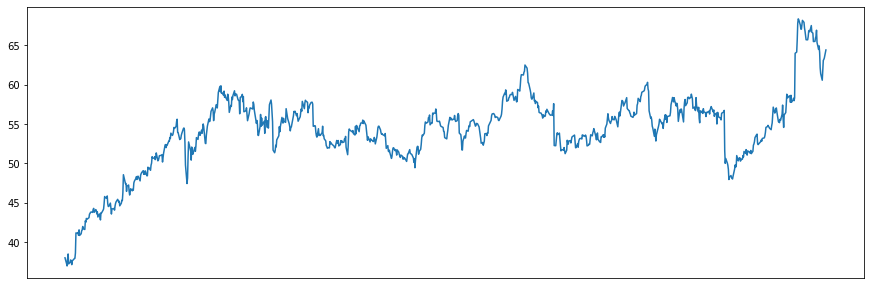

In [84]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.xticks([])
plt.plot(data['Close'])
plt.show()

# I. Basic operations in TSA

### 1. Time resampling
- Time re-sampling : Group-by aggregration but instead of aggregating by attributes, time resampling aggregate by certain **Time frequency**
- Example : Average price per month - week - year

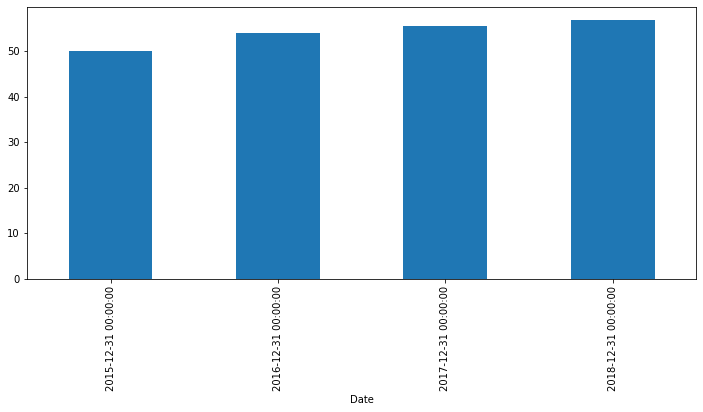

In [85]:
# Example : Mean stock price of starbucks yearly
# Resample : Daily --> Annually ('A' stands for "Annually")
fig, ax = plt.subplots(figsize=(12, 5))
data.resample(rule='A').mean()['Close'].plot(kind='bar')
plt.show()

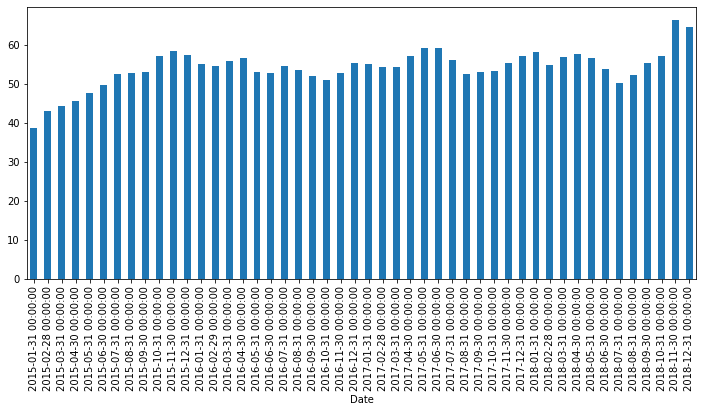

In [86]:
# Example : Mean stock price of starbucks monthly
# Resample : Daily --> Monthly
fig, ax = plt.subplots(figsize=(12, 5))
data.resample(rule='M').mean()['Close'].plot(kind='bar')

plt.show()

In [87]:
# Example : Custom aggregation function - Return closing stock of first day of the year
def first_day_of_year(entry):
    if(len(entry)): # If this group has more than 1 entries
        return entry[0] # Return the first entry
    
data.resample(rule='A').apply(first_day_of_year)

,Close,Volume
Date,,
2015-12-31,38.0061,6906098
2016-12-31,55.0780,13521544
2017-12-31,53.1100,7809307
2018-12-31,56.3243,7215978


### 2. Time-shifting
- Sometimes you need to shift your data frame up or down along the time-series index. Pandas has built-in functionalities for this.
- Application : 
    - Calculate moving average
    - Calculate rate of changes given a time interval
    - [...]

In [88]:
# Example : Populate each row the values of the exact PREVIOUS row
# Shift : Forward
# The original dataset
data.head(3) 

,Close,Volume
Date,,
2015-01-02,38.0061,6906098
2015-01-05,37.2781,11623796
2015-01-06,36.9748,7664340


In [89]:
data.shift(1).head(3)

,Close,Volume
Date,,
2015-01-02,NaN,NaN
2015-01-05,38.0061,6906098.0
2015-01-06,37.2781,11623796.0


In [90]:
# Example : Populate each row the values of the exact NEXT row
# Shift : Backward
# The original dataset
data.tail(3)

,Close,Volume
Date,,
2018-12-27,63.20,11308081
2018-12-28,63.39,7712127
2018-12-31,64.40,7690183


In [91]:
data.shift(-1).tail(3)

,Close,Volume
Date,,
2018-12-27,63.39,7712127.0
2018-12-28,64.40,7690183.0
2018-12-31,NaN,NaN


### 3. Rolling and Exanding
#### 3.1. Rolling windows
- Rolling : Aggregate data based on a fixed size moving window

<AxesSubplot:xlabel='Date'>

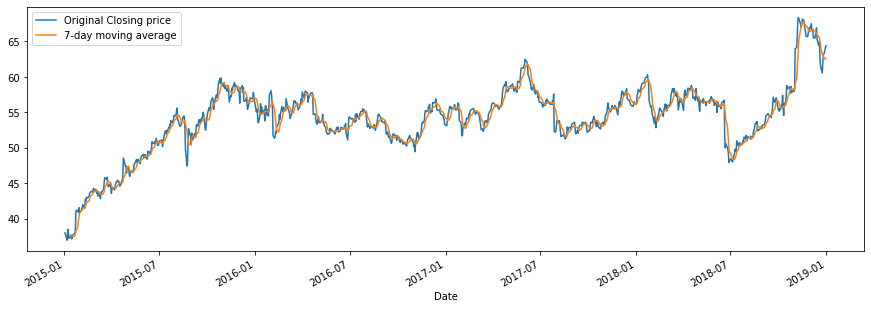

In [92]:
# Example : Moving average for every 7 days
fig, ax = plt.subplots(figsize=(15,5))
data['Close'].plot(label='Original Closing price', legend=True)
data.rolling(window=7).mean()['Close'].plot(label='7-day moving average', legend=True)

<AxesSubplot:xlabel='Date'>

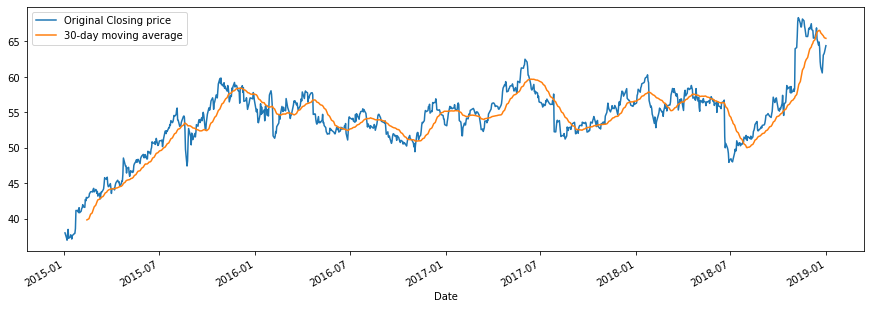

In [93]:
# Example : 30-day moving average
# Notice : The larger the rolling window, the MA line gets smoother
fig, ax = plt.subplots(figsize=(15,5))
data['Close'].plot(label='Original Closing price', legend=True)
data.rolling(window=30).mean()['Close'].plot(label='30-day moving average', legend=True)

#### 3.2. Expanding windows
- Expanding aggregates every data point up till current point in time. Unlike rolling window, expanding window expands its size over time.

<AxesSubplot:xlabel='Date'>

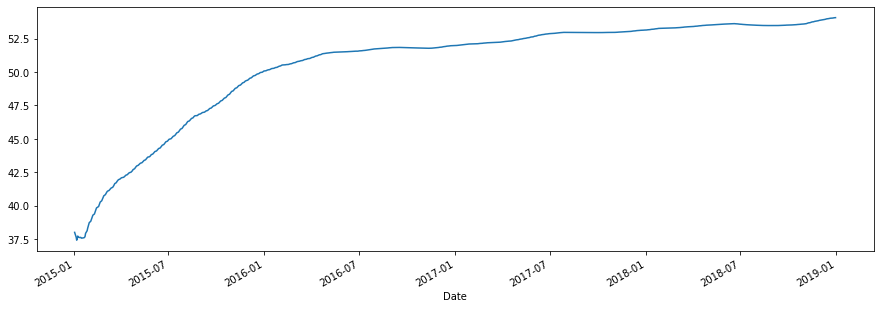

In [94]:
fig, ax = plt.subplots(figsize=(15, 5))
data['Close'].expanding().mean().plot()

# II. Forecasting in TSA

## 1. ETS decomposition
- ETS decomposition breaks down your time-series data into Error - Trend and Seasonality.
    - Error : The noise in the time series (Things not explained by trend/seasonality)
    - Trend : The long-term trend in the time-series
    - Seasonality : The short-term pattern/cycle in your time series

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


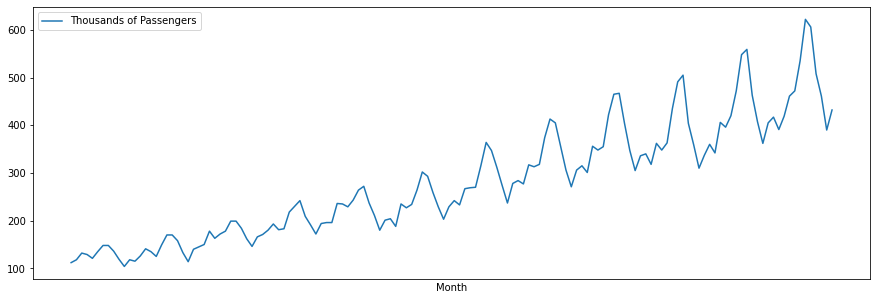

In [95]:
# Example : ETS decomposition of the airlines passengers dataset
fig, ax = plt.subplots(figsize=(15, 5))

data2 = pd.read_csv('airline_passengers.csv', index_col='Month').dropna()
data2['Thousands of Passengers'].plot(label='Thousands of Passengers', legend=True)
data2.index = pd.to_datetime(data2.index)

plt.xticks([])
plt.show()

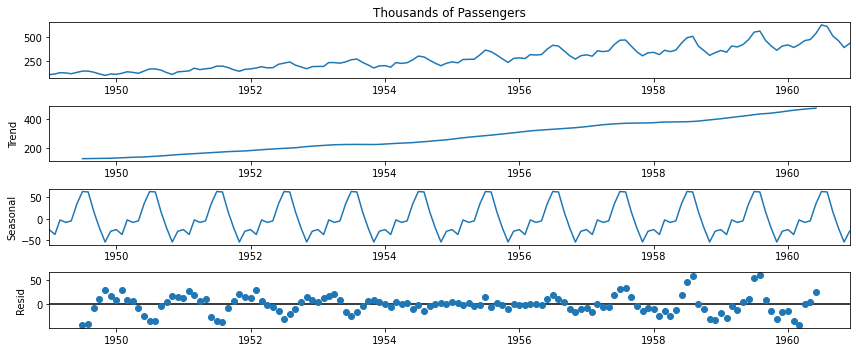

In [97]:
# Two types of ETS decompositions :
# - Additive : Applied when trend and seasonality appears linear. i.e. Rate of change is const
# - Multiplicative : Applied when the rate of change happens in non-linear manner.
#                    E.g : the increase of passenger doubles every year.

# E.g : Additive ETS decomposition in statsmodel
result = seasonal_decompose(data2['Thousands of Passengers'], model='additive')
result.plot()
plt.show()

## 2. Exponential Weighted Moving Average (EWMA)
- A simple MA can allow us to visualize the trend of our time-series at some level
- The problem with simple MA is old and new data is weighted equally
- It would be nice to have more recent data weighted more than older data - EWMA


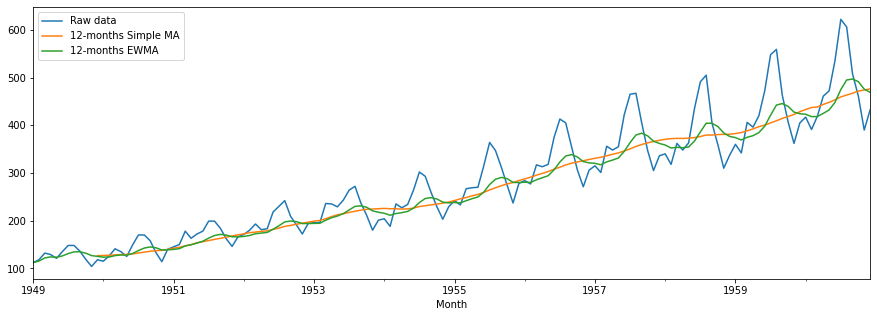

In [104]:
fig, ax = plt.subplots(figsize=(15, 5))

data2['Thousands of Passengers'].plot(label='Raw data')
data2['Thousands of Passengers'].rolling(12).mean().plot(label='12-months Simple MA')
data2['Thousands of Passengers'].ewm(span=12).mean().plot(label='12-months EWMA')
plt.legend()
plt.show()

## 3. Holt-winters method
- Unlike exponetial smoothing methods, Holt-winters method decompose your time-series into various components (Levels, Trends, Seasonalities), smooth them and make forecast out of your decomposed components.

/home/hieu/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


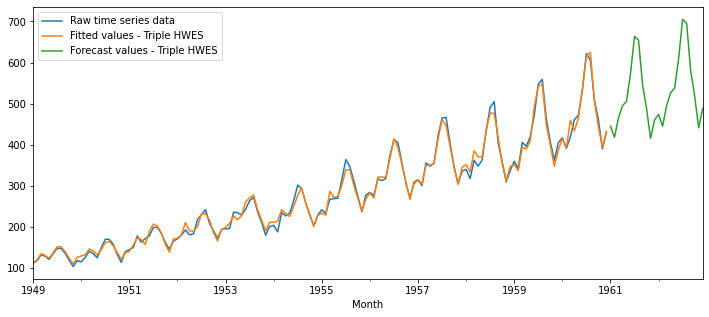

In [108]:
# Example of an additive triple-HWES
model = ExponentialSmoothing(data2['Thousands of Passengers'],
                                    trend='add',seasonal='mul',
                                    seasonal_periods=12).fit()

fitted_values = model.fittedvalues
forecast_values = model.forecast(24) # Next 2 years forecast

data2['Thousands of Passengers'].plot(label='Raw time series data')
fitted_values.plot(label='Fitted values - Triple HWES')
forecast_values.plot(label='Forecast values - Triple HWES')

plt.legend()
plt.show()

## 4. Auto-regression (AR)

/home/hieu/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/hieu/.local/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


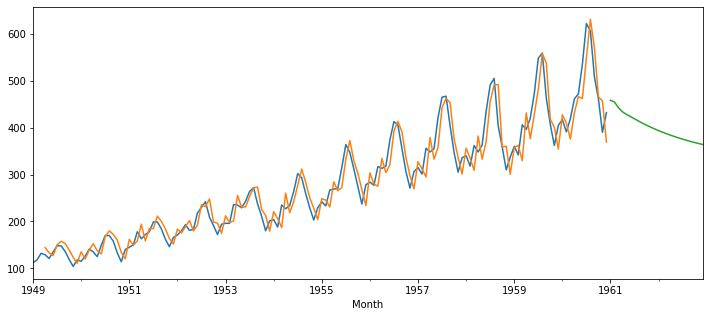

In [130]:
# If you just make a wild guess of the lags, the forecast may be very bad
model = AutoReg(data2['Thousands of Passengers'], lags=3).fit()

fitted_values = model.fittedvalues
forecast_values = model.forecast(24)

data2['Thousands of Passengers'].plot(label='Raw time series data')
fitted_values.plot(label='Fitted values - AutoReg')
forecast_values.plot(label='Forecast values - AutoReg')
plt.show()

/home/hieu/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/hieu/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/hieu/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/hieu/.local/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


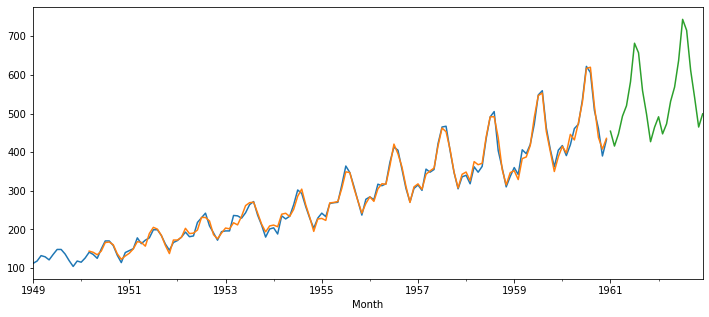

In [142]:
# Determine the optimal lag first
model = ar_select_order(data2['Thousands of Passengers'], maxlag=20, ic='aic') # Use Akaike's Information Criterion
optimal_ord = model.ar_lags[-1]

# Re-fit the AR model
model = AutoReg(data2['Thousands of Passengers'], lags=optimal_ord).fit()

fitted_values = model.fittedvalues
forecast_values = model.forecast(24)

data2['Thousands of Passengers'].plot(label='Raw time series data')
fitted_values.plot(label='Fitted values - AutoReg')
forecast_values.plot(label='Forecast values - AutoReg')
plt.show()